Adv ML Final Project <br>
Identifying Anti-LGBTQIA-Discriminatory State Bills <br>
Carolyn Vilter <br>
23.05.01

## Data exploration and baseline model

### Data exploration

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

import torchmetrics
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryPrecision

#from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay

#nltk.download('stopwords')
from nltk.corpus import stopwords

In [35]:
# Combined bill text / discriminatory label datasets
df = pd.read_csv("data/ML_text_data_new.csv")
df

,doc_id,text,discriminatory
0,2765271,Enrolled HB LAWS OF ALASKA Sourc...,0
1,2776866,HBa -- HB New Text Underlined [DELETED TE...,0
2,2732779,HBa -- HB New Text Underlined [DELETED TE...,0
3,2693088,SBA -- SB New Text Underlined [DELETED TE...,0
4,2767132,SBA -- SB New Text Underlined [DELETED TE...,0
...,...,...,...
2655,2758370,As Amended by Senate Committee As Amended by H...,1
2656,2759820,FIRST REGULAR SESSION HOUSE COMMITTEE SUBSTITU...,1
2657,2742094,HOUSE BILL No. AN ACT concerning education; ...,1
2658,2626885,Stricken language would be deleted from and un...,1


In [36]:
# Drop bills with no text
df = df[df['text'].notna()]
df

,doc_id,text,discriminatory
0,2765271,Enrolled HB LAWS OF ALASKA Sourc...,0
1,2776866,HBa -- HB New Text Underlined [DELETED TE...,0
2,2732779,HBa -- HB New Text Underlined [DELETED TE...,0
3,2693088,SBA -- SB New Text Underlined [DELETED TE...,0
4,2767132,SBA -- SB New Text Underlined [DELETED TE...,0
...,...,...,...
2655,2758370,As Amended by Senate Committee As Amended by H...,1
2656,2759820,FIRST REGULAR SESSION HOUSE COMMITTEE SUBSTITU...,1
2657,2742094,HOUSE BILL No. AN ACT concerning education; ...,1
2658,2626885,Stricken language would be deleted from and un...,1


In [37]:
stop_words = set(stopwords.words('english'))

In [38]:
stop_words.update(['.', ',', '(', ')', '--', 'hba', 'sba', 'hb', 'sb', 'house', 'senate', 'session'
                   'hbb', 'sshb', '-ls\\s', '-ls\\a', 'sbb', 'cssb', 'cra', '-ls\\b', 'legislature'])

In [39]:
data_raw = zip(df['discriminatory'], df['text'])
data = [(label, tokens) for (label, tokens) in data_raw] 

In [40]:
len(data)

2660

In [41]:
# Bill text cleanup function
def clean_text(text):
    '''
    Basic function for cleaning mis-delimited or otherwise messy bill texts.
    '''
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = re.sub(" {2,}", " ", text)
    return text

In [42]:
tokenizer = get_tokenizer('basic_english')

In [43]:
df["text"]

0         Enrolled HB  LAWS OF ALASKA            Sourc...
1         HBa -- HB    New Text Underlined [DELETED TE...
2         HBa -- HB    New Text Underlined [DELETED TE...
3         SBA -- SB    New Text Underlined [DELETED TE...
4         SBA -- SB    New Text Underlined [DELETED TE...
                              ...                        
2655    As Amended by Senate Committee As Amended by H...
2656    FIRST REGULAR SESSION HOUSE COMMITTEE SUBSTITU...
2657    HOUSE BILL No.  AN ACT concerning  education; ...
2658    Stricken language would be deleted from and un...
2659        HB HFLR  Page   BOLD FACE  denotes Committ...
Name: text, Length: 2660, dtype: object

In [44]:
# Try tokenizing bill texts; identify short/messy texts
tokenized_texts = []
min_len = float('inf')
max_len = 0
lengths = []
num_weird_bills = 0

for text in df["text"]:
    text = clean_text(text)
    text = tokenizer(text)
    text = [w for w in text if w not in stop_words]
    tokenized_texts.append(text)

    num_tokens = len(text)
    lengths.append(num_tokens)
    if num_tokens > max_len:
        max_len = num_tokens
    if num_tokens < min_len:
        min_len = num_tokens
    if num_tokens < 100:
        # print short bill texts for inspection
        #print(text)
        num_weird_bills += 1

# print key info
print("min length:", min_len, ", max length:", max_len)
print("num bills:", len(tokenized_texts), ", num weird bills:", num_weird_bills)

min length: 6 , max length: 133364
num bills: 2660 , num weird bills: 202


<BarContainer object of 20 artists>

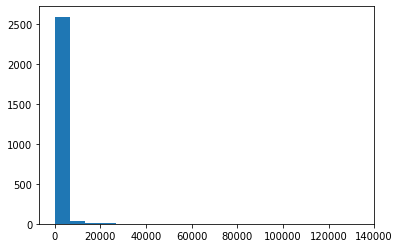

In [45]:
# Get a sense of how many tokens are in most bill texts
_, _, plot = plt.hist(lengths, bins=20)
plot

### Data prep for CBOW model

In [46]:
# Turn our labels and cleaned-up text into a coherent dataset (list of tuples)
data = []
for label, tokens in zip(df["discriminatory"], tokenized_texts):
    #single_string = ""
    #for token in text:
    #    single_string = single_string + token + " "
    data.append((label, tokens))
len(data)

2660

In [47]:
# Turn our data into custom torch Dataset
    
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.vocab = build_vocab_from_iterator(
            tokenized_texts, specials=["<unk>"], min_freq = 10)
        self.vocab.set_default_index(self.vocab['<unk>'])

    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return (len(self.data))

    def __getitem__(self, idx):
        label, tokenized_text = self.data[idx]
        #return label, tokenized_texts
        tokenized_texts_idxs = self.vocab.lookup_indices(tokenized_text)
        #print(torch.LongTensor([label]), torch.LongTensor(tokenized_texts_idxs))
        return (torch.LongTensor([label]), torch.LongTensor(tokenized_texts_idxs))    

In [48]:
dataset = CustomDataset(data)

In [51]:
# GloVe
# Change dir!
#VECTOR_CACHE_DIR  = "CAPP/Adv_ML/.vector_cache"
VECTOR_CACHE_DIR = '/Users/carolynvilter/Documents/MSCAPP_Y2Q3/adv_ml/.vector_cache'
glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

In [52]:
def collate_into_cbow(batch):
    ''' 
    Custom label and text collation function for dataloader
    '''
    size = len(batch)
    lt = torch.zeros(size,)
    tt = torch.zeros(size, 300)

    for i, (label, token_list) in enumerate(batch):
        # create label tensor
        lt[i] = int(label)

        # create cbow using glove
        #all_embeddings = glove.get_vecs_by_tokens([vocab.lookup_token(x) for x in token_list])
        all_embeddings = glove.get_vecs_by_tokens(token_list)
        tt[i] = torch.mean(all_embeddings, dim = 0)
    
    lt = lt.type(torch.LongTensor)

    return (lt, tt)

In [53]:
# Create dataloader
dataloader = DataLoader(data, batch_size=16, shuffle=False, 
                        collate_fn=collate_into_cbow)

In [54]:
# check dataloader
for idx, (lt, tt) in enumerate(dataloader):
    print(idx, lt.shape, tt.shape)
    if idx == 4: 
        break

0 torch.Size([16]) torch.Size([16, 300])
1 torch.Size([16]) torch.Size([16, 300])
2 torch.Size([16]) torch.Size([16, 300])
3 torch.Size([16]) torch.Size([16, 300])
4 torch.Size([16]) torch.Size([16, 300])


In [ ]:
# check dataloader cont.
for idx, (lt, tt) in enumerate(dataloader):
    print(idx, lt, tt)
    if idx == 2: 
        break

0 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([[-0.2013, -0.0789, -0.1366,  ..., -0.2602, -0.0005,  0.0636],
        [-0.0493, -0.0298, -0.1266,  ..., -0.2740, -0.0638,  0.0763],
        [-0.1588,  0.0212, -0.0797,  ..., -0.2016, -0.0786,  0.0226],
        ...,
        [-0.1786, -0.1275, -0.0931,  ..., -0.2511, -0.0197,  0.1057],
        [-0.1067,  0.0268, -0.1053,  ..., -0.1384, -0.0687, -0.0143],
        [-0.0390,  0.0609, -0.0723,  ..., -0.2096, -0.0985,  0.0271]])
1 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([[-0.0579, -0.0076, -0.0447,  ..., -0.2611,  0.0171,  0.0055],
        [-0.1819, -0.0463, -0.0644,  ..., -0.2075, -0.0130,  0.0195],
        [-0.1436, -0.0371, -0.0810,  ..., -0.2434, -0.0409,  0.0026],
        ...,
        [-0.1269, -0.0573, -0.0621,  ..., -0.1794,  0.0445,  0.0519],
        [-0.0899, -0.0338, -0.1418,  ..., -0.1995,  0.0271,  0.1151],
        [-0.1380, -0.0392, -0.0465,  ..., -0.1160, -0.0685, -0.0034]])
2 tensor([0, 0

In [ ]:
# check dataloader cont.
check = 0
for idx, (lt, tt) in enumerate(dataloader):
    for val in lt:
        if val == 1:
            check += 1
print(check)
print(sum(df["discriminatory"]))

812
812


### CBOW model

In [ ]:
# Model class
class CBoWClassifier(nn.Module):
    ''' 
    Model class for our baseline model, a continuous bag of words logistic reg.
    One linear layer and a softmax transformation
    Takes number of labels and vocabulary size as inputs
    '''
    def __init__(self, num_labels, vocab_size):
        # nn.Module init
        super(CBoWClassifier, self).__init__()
        # linear layer: affine map given input dim, output dim
        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, cbow_vec):
        # pass through linear layer, then softmax
        linear_output = self.linear(cbow_vec)
        output = F.log_softmax(linear_output, dim = 1)
        return output

In [ ]:
# Training function
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    '''' 
    Train one epoch of the CBoW classifier and print loss at intervals
    '''
    model.train() # Sets the model in training mode.
    log_interval = 20

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [ ]:
PRED_ALL_EPOCHS = 0

In [ ]:
# Probabilities for ROC and confusion matrix
def get_probabilites(dataloader):
    ''' 
    Return predicted y probabilites for use in creating ROC curve 
    and confusion matrix
    '''
    model.eval()
    y_list = []
    y_pred_list = []
    with torch.no_grad(): 
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            pred_label = log_probs.argmax(1)
            y_list.append(label)
            y_pred_list.append(pred_label)
    y = torch.cat(y_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y, y_pred

In [27]:
# Accuracy function
def get_accuracy(dataloader):
    ''' 
    Given a trained model and a (test or validation) dataloader, evaluate and
    return the accuraccy, recall, and precision of the model on the data.
    '''

    global PRED_ALL_EPOCHS

    model.eval()

    with torch.no_grad():
        total_correct, total_examples = 0, 0
        all_recall = []
        all_precision = []
        recall_metric = BinaryRecall()
        precision_metric = BinaryPrecision()

        for _, (label, text) in enumerate(dataloader):
            output = model(text)
            pred_label = output.argmax(1)

            # count of predicted "1"s for ref while developing
            d_count = sum(pred_label)
            if d_count > 0:
                PRED_ALL_EPOCHS += d_count
                print(f"Predicted discriminatory")
            num_examples = len(label)

            # precision and recall
            print("pred_label", pred_label)
            print("label", label)
            recall = recall_metric(pred_label, label)
            print("recall", recall)
            precision = precision_metric(pred_label, label)
            print("precision", precision)
            all_recall.append(recall)
            all_precision.append(precision)

            # accuracy
            num_correct = sum(torch.eq(pred_label, label))
            total_correct += num_correct
            total_examples += num_examples

    accuracy = total_correct/total_examples

    return accuracy, np.mean(all_recall), np.mean(all_precision)

In [28]:
# Prep for data split
len_train = int(len(data) * .8)
len_valid = int((len(data) - len_train)/2)
len_test = len(data) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

2128 train 266 validation 266 testing


In [55]:
# Set parameters, create model instance, create split dataloaders
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

num_labels = len(set([label for (label, text) in train_data]))
vocab_size = len(glove.get_vecs_by_tokens("test"))
model = CBoWClassifier(num_labels, vocab_size)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)

### Accuracy frames of reference

In [57]:
# (you'd be right this % of the time if you always guessed non-discriminatory)
for dataset, name in zip([train_data, valid_data, test_data], 
                         ("train_data", "valid_data", "test_data")):
    total_count = 0
    count_1s = 0
    for bill in dataset:
        count_1s += bill[0]
        total_count += 1
    print(f"percent of bills labeled '1' in the %s:" %name, 1 - count_1s / total_count)

percent of bills labeled '1' in the train_data: 0.6945488721804511
percent of bills labeled '1' in the valid_data: 0.6992481203007519
percent of bills labeled '1' in the test_data: 0.6917293233082706


At iteration 20 the loss is 0.749.
At iteration 40 the loss is 0.665.
At iteration 60 the loss is 0.735.
At iteration 80 the loss is 0.785.
At iteration 100 the loss is 0.747.
At iteration 120 the loss is 0.727.
Predicted discriminatory
pred_label tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])
recall tensor(1.)
precision tensor(0.3125)
Predicted discriminatory
pred_label tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
recall tensor(1.)
precision tensor(0.1875)
Predicted discriminatory
pred_label tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
recall tensor(1.)
precision tensor(0.1250)
Predicted discriminatory
pred_label tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0])
recall tensor(1.)
precision tensor(

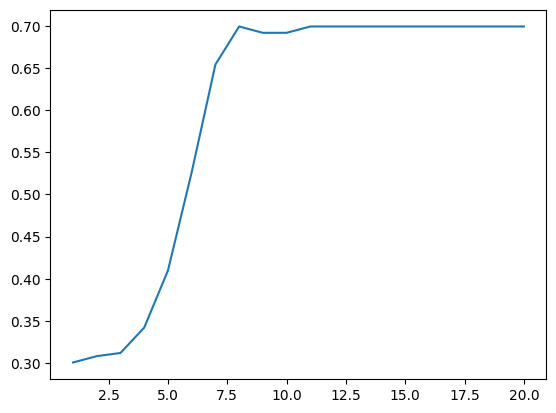

In [58]:
# Train the CBOW
EPOCHS = 20 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=.0001)

accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(train_dataloader, optimizer)

    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)

    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)

    print()
    print(f'''Epoch: {epoch}, validation accuracy: {accuracy_val:.3f}, 
            recall: {recall_val}, precision: {precision_val}.''')
    print()

if type(PRED_ALL_EPOCHS) == torch.Tensor:
    PRED_ALL_EPOCHS = PRED_ALL_EPOCHS.item()

print(f"Over all %s epochs, predicted disciminatory a total of %s times" %(EPOCHS, PRED_ALL_EPOCHS))
    
plt.plot(range(1, EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

In [59]:
print(precisions_val)
print(recalls_val)
print(precisions_train)
print(recalls_train)

[0.2985294, 0.3010621, 0.29934642, 0.3034529, 0.3005844, 0.3036839, 0.38578433, 0.39215687, 0.11764706, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 0.9794117, 0.95294124, 0.7465687, 0.4779412, 0.3245098, 0.17107843, 0.01764706, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.30610904, 0.3065163, 0.3076882, 0.30036834, 0.28646547, 0.27565804, 0.29367766, 0.3283208, 0.17042607, 0.075187966, 0.015037594, 0.007518797, 0.007518797, 0.007518797, 0.007518797, 0.007518797, 0.007518797, 0.007518797, 0.007518797, 0.007518797]
[1.0, 0.9960318, 0.97836554, 0.9052452, 0.71541655, 0.47712845, 0.2693251, 0.12409894, 0.04367168, 0.017427498, 0.002953813, 0.00093984965, 0.0007518797, 0.0008354219, 0.0010741139, 0.0015037594, 0.0012531328, 0.00093984965, 0.0018796993, 0.0025062656]


### Additional plots

Accuracy

Text(0, 0.5, 'Accuracy')

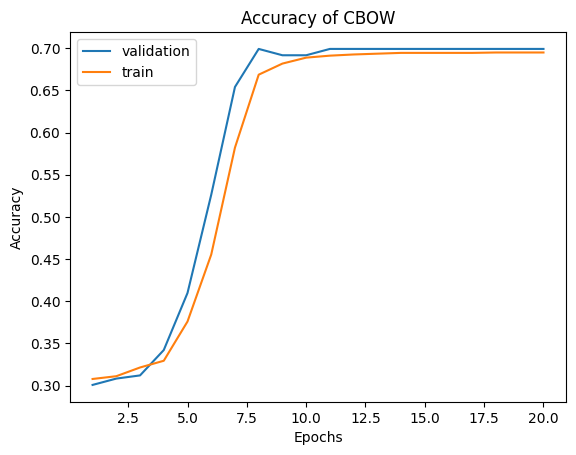

In [60]:
plt.plot(range(1, EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of CBOW')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Recall

Text(0, 0.5, 'Recall')

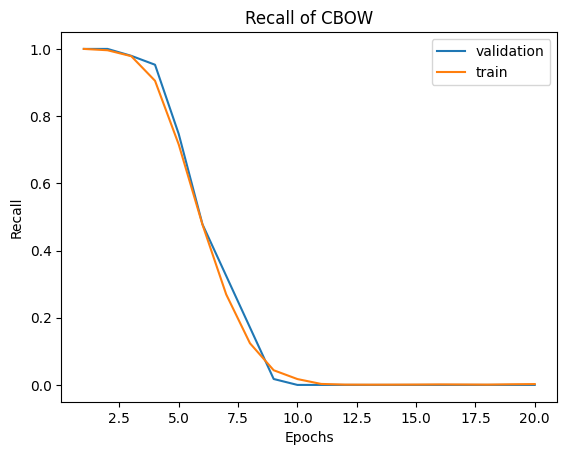

In [61]:
plt.plot(range(1, EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train, label='train')
plt.title('Recall of CBOW')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')

Precision

Text(0, 0.5, 'Precision')

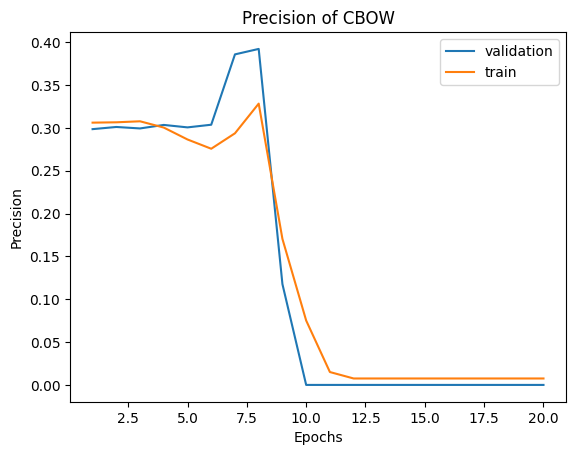

In [62]:
plt.plot(range(1, EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train, label='train')
plt.title('Precision of CBOW')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')

ROC curve

In [63]:
y, y_prob = get_probabilites(test_dataloader)

Text(0, 0.5, 'True Positive Rate')

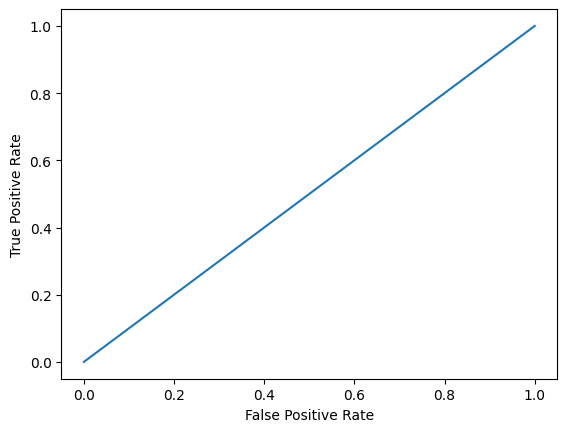

In [64]:
fpr, tpr, thresholds = roc_curve(y, y_prob)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Confusion matrix

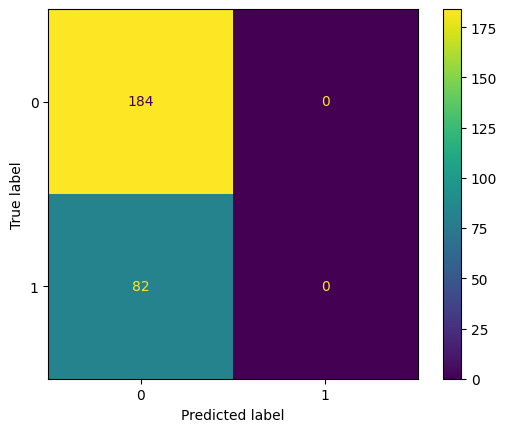

In [65]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()